# Installing Hub

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
!pip3 install hub --quiet

# Run below cells and restart the runtime
# if you are running it in colab
# import os
# os.kill(os.getpid(), 9) 

# Download raw dataset

In [1]:
from IPython.display import clear_output

In [ ]:
# Download Dataset here
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip
!wget https://github.com/bgshih/cocotext/releases/download/dl/cocotext.v2.zip
!unzip cocotext.v2.zip

# Download COCO-Text Utility file
!wget https://raw.githubusercontent.com/bgshih/coco-text/master/coco_text.py
clear_output()

In [4]:
from PIL import Image 
import numpy as np 
import os
from matplotlib import pyplot as plt
import pycocotools.mask as maskutil
import time
from tqdm import tqdm
import coco_text
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Resources
1. coco_text python code: [Github - bgshih - COCO-Text](https://raw.githubusercontent.com/bgshih/coco-text/master/coco_text.py) <br>
2. coco_text author demo: [Github - bgshih - COCO-Text](https://github.com/bgshih/coco-text/blob/master/coco_text_Demo.ipynb) <br>
3. Activeloop COCO example: [Github - ActiveloopAI - COCO](https://github.com/activeloopai/examples/blob/main/coco/upload_coco.ipynb) <br>
4. COCO-Text website: https://bgshih.github.io/cocotext/ <br>

# Creating dataset on hub

**Activeloop API** : https://docs.activeloop.ai/api-basics

In [5]:
import hub

# Login to ActiveLoop

%env BUGGER_OFF=True
!activeloop login -u username -p password
!activeloop reporting --off

env: BUGGER_OFF=True
Successfully logged in to Activeloop.


In [6]:
images_path = 'train2014/'
json_path = 'cocotext.v2.json'

In [7]:
ct = coco_text.COCO_Text(json_path)

loading annotations into memory...
0:00:03.401045
creating index...
index created!


In [1]:
def generate_mask(array, shape):
    height, width = shape
    seg = np.array(array)
    compactedRLE = maskutil.frPyObjects([seg], width, height)
    mask = maskutil.decode(compactedRLE)
    mask = np.reshape(mask,(width, height))
    return mask

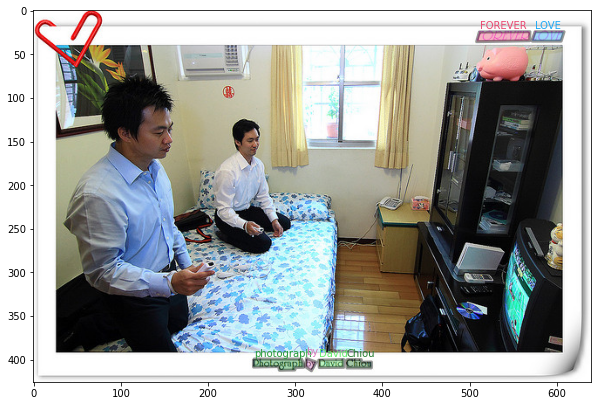

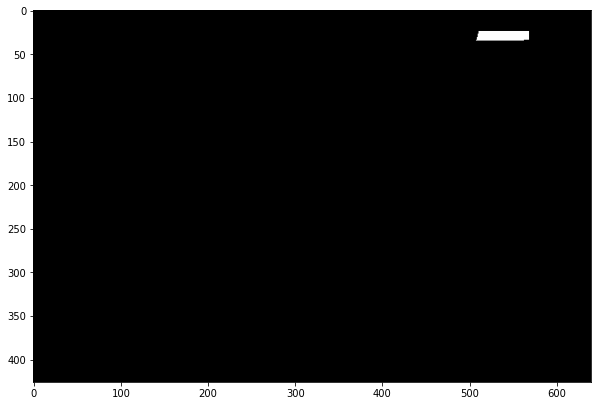

In [9]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
# pick one at random
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

I = io.imread(os.path.join(images_path,img['file_name']))
plt.figure()
plt.imshow(I)
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns, show_mask=True)
plt.show()

# Example of generating a mask with generate_mask() function
width, height = Image.open(os.path.join(images_path,img['file_name'])).size
plt.imshow(generate_mask(anns[0]['mask'], (width, height)), cmap='gray')
plt.show()

In [10]:
class_labels = ['handwritten', 'machine printed']
language_labels = ['english', 'not english']
legibility_labels = ['illegible', 'legible']

In [31]:
# ct.train or ct.val
dataset_type = ct.train

# Image ids for uploading
img_ids = sorted(ct.getImgIds(imgIds=dataset_type)) 

In [ ]:
# train or val
sub_dataset_name = 'train'
hubpath = 'hub://<username>/coco-text-{}'.format(sub_dataset_name)
ds = hub.dataset(hubpath)

In [ ]:
limit_images = None # 100
start_time = time.time()

with ds:
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpg')
    ds.create_tensor('images_meta', htype = 'json')
    ds.create_tensor('masks', htype = 'binary_mask', sample_compression = 'lz4')
    ds.create_tensor('boxes', htype = 'bbox')
    ds.create_tensor('areas', dtype = 'uint32')
    ds.create_tensor('classes', htype='class_label', class_names=class_labels)
    ds.create_tensor('languages', htype='class_label', class_names=language_labels)
    ds.create_tensor('legibilities', htype='class_label', class_names=legibility_labels)
    ds.create_tensor('utf8_strings', htype='list')
    
    # Boxes -> left, top, width, height
    ds.boxes.info.update(coords = {'type': 'pixel', 'mode': 'LTWH'})
    
    
    ## ---- Iterate through each image and upload data ----- ##
    for index, img_id in enumerate(tqdm(img_ids)):
        img_coco = ct.loadImgs(img_id)[0]
        ann_ids = ct.getAnnIds(imgIds=img_coco['id'])
        anns = ct.loadAnns(ann_ids)
        img_fn = os.path.join(images_path, img_coco['file_name'])
        img = Image.open(img_fn)
        dims = img.size
        
        #Iterate through annotations and parse each
        
        #First Create empty arrays for all annotations
        masks = np.zeros((dims[1], dims[0], len(anns)))
        boxes = np.zeros((len(anns),4)) 
        areas = np.zeros((len(anns)))
        classes = np.zeros((len(anns)))
        languages = np.zeros((len(anns)))
        legibilities = np.zeros((len(anns)))
        utf8_strings = []
        
        #Then populate the arrays with the annotations data
        for i, ann in enumerate(anns):
            
            if 'mask' not in ann:
                print('--- No mask found in annotations. ---')
                print('Annotation length: {}'.format(len(anns)))
                print('--- image id: {} ---'.format(img_id))
                
            masks[:,:,i] = generate_mask(ann['mask'], dims)
            boxes[i,:] = ann['bbox']
            
            # Do a brute force search and make no assumptions between order of relationship of category ids
            classes[i] = class_labels.index(ann['class'])
            languages[i] = language_labels.index(ann['language'])
            legibilities[i] = legibility_labels.index(ann['legibility'])
            areas[i] = ann['area']
            utf8_strings.append(ann['utf8_string'])
  
        #Append data to hub. Only do this after all annotations have been parsed.
        ds.append({
            'images' : hub.read(img_fn, verify = True),
            'images_meta' : img_coco,
            'masks' : masks.astype('bool'),
            'boxes' : boxes.astype('float32'),
            'areas' : areas.astype('uint32'),
            'classes' : classes.astype('uint32'),
            'languages' : languages.astype('uint32'),
            'legibilities' : legibilities.astype('uint32'),
            'utf8_strings' : utf8_strings
        })
            
        if index == limit_images : break;
            
    
end_time = time.time()

print('Upload took {} seconds'.format(end_time-start_time))